# Homework 9
In this homework, you will explore neural networks, writing code to complete forward and backward passes for a fully-connected network. Having done this, you will train these networks with the goal of classifying images of apparel into the type (from the Fashion MNIST dataset). You will finally upload your predictions on the test set we give you to a Kaggle competition.

There are a number of programming **tasks** and **quiz questions** in this homework.
- For **tasks**, you will need to either **add code between comments "`#### TASK N CODE`"** to complete them or **modify code between those comments**. **DO NOT delete the comments "#### TASK N CODE". This is for graders' reference and you might not get full points if you tamper with these comments.**
- For **quiz questions**, you will need to answer in a few sentences between the given lines.
- For **optional tasks**, you are **NOT required to turn them in**. However, we encourage you to complete them as they are good practice.
- For **challenge-optional tasks**, you are **NOT required to turn them in**. However, you will receive extra credit for completing the challenge.

-----

We will first import libraries.
- We provide you with a few relevant functions in the `utils` module. The `linclass` module has a bunch of linear classifiers that we also provided you in the previous homework.
- In this assignment, we will program neural networks with different network operations represented as classes. Thus, we will need a common "abstract" class and several abstract methods; `abc` module provides these.

In [3]:
!wget -O utils.py https://www.dropbox.com/scl/fi/h2i6hzhxdz3bvyrcifr6k/utils.py?rlkey=ytpqbrd2l1xprmqyuacu84lod
!wget -O linclass.py https://www.dropbox.com/scl/fi/l9zxfj6hw48f2klslp9e4/linclass.py?rlkey=7acwguylzhicwel5f0tydfm7u

--2025-03-04 15:08:06--  https://www.dropbox.com/scl/fi/h2i6hzhxdz3bvyrcifr6k/utils.py?rlkey=ytpqbrd2l1xprmqyuacu84lod
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uca9bbf68bfea80513e5d11a8248.dl.dropboxusercontent.com/cd/0/inline/ClTxMgn5ZHZB3gtNuX9zsKy34goLuRahJgmTmeoOD7ZCWbl5cJ_R8ZaMxwo81SLolcZ1yH-qof9ADNQ8H8CNHTLm-9L2yS8I2a-1Eabpq2b95t13N9gXWsubRqYXjqI7HLkpdt3_lwnD7nOB-xKv4u90/file# [following]
--2025-03-04 15:08:07--  https://uca9bbf68bfea80513e5d11a8248.dl.dropboxusercontent.com/cd/0/inline/ClTxMgn5ZHZB3gtNuX9zsKy34goLuRahJgmTmeoOD7ZCWbl5cJ_R8ZaMxwo81SLolcZ1yH-qof9ADNQ8H8CNHTLm-9L2yS8I2a-1Eabpq2b95t13N9gXWsubRqYXjqI7HLkpdt3_lwnD7nOB-xKv4u90/file
Resolving uca9bbf68bfea80513e5d11a8248.dl.dropboxusercontent.com (uca9bbf68bfea80513e5d11a8248.dl.dropboxusercontent.com)... 162.125.3.15
Connecting to uca9bbf68bfea80513e5d11a8

In [2]:
import abc
from typing import List, Optional, Tuple

import linclass
import numpy as np
import matplotlib.pyplot as plt
import utils

In [3]:
SEED = 0
np.random.seed(0)

## Neural Networks

As discussed in lecture, neural networks are Directed Acyclic Graphs (DAGs) with input and output nodes, where each node is associated with an "activation" function, and where the edges have weights. Neural networks can be represented as DAGs in code using a "computational graph". In fact, many libraries such as PyTorch and Tensorflow choose to do so.

We will follow a code structure similar to PyTorch, though we will limit the scope of this homework to a path in a DAG. A path in a DAG corresponds to a Sequential neural network, called as such because it comprises of a sequence of layers (collection of units of nodes) where the output of one layer is the input of the next layer in the sequence.

We start by defining a `Module` that defines a node or a collection of nodes. A `Module` is an abstract view of the fundamental element of a neural network. It defines several attributes and methods, some of which must be implemented by the derived classes.
- `train` is a flag to denote whether the module is in training or evaluation mode. We will see how this is important later. This flag is controlled by `train_mode()` and `eval_mode()` methods.
- `forward()` and `backward()` methods do forward and backward passes of the module (recall the discussion from recitation).
    - Inside `forward()`, attributes `_input` and `_output` must be assigned. These correspond to the input of the module (`x`) and the output (after whatever operations the module does in the forward pass).
    - Inside `backward()`, attributes `_grad_output` and `grad_input` must be assigned. These correspond to the gradient of the loss w.r.t. module's outputs and module's inputs respectively. To do the backward pass, attributes `_input` and `_output` containing the values of the forward pass might come handy.
- `get_params()` and `set_params()` are getter and setter functions for _all the **trainable** parameters_ of the module.
- `get_grad_params()` method returns the gradient of the loss w.r.t. the **trainable** parameters.


In [4]:
class Module(abc.ABC):
    '''
    A module defines a sub-graph G' = (V, E) in the DAG G that represents a
    neural network. Therefore G' is a subset of G. An instantiation of a module
    thus represents a realization of a subgraph, comprising of a set of nodes and
    their connections.
    '''
    def __init__(self):
        # Train mode or eval mode
        self.train = True

        # Forward pass cache
        self._input = None
        self._output = None

        # Backward pass cache
        self._grad_output = None
        self._grad_input = None

    @abc.abstractmethod
    def forward(self, x: np.ndarray):
        '''
        Computes the forward pass z = f(x) where f is the function represented by
        the module, x is the input, and z is the output of the forward pass.

        Assigns to attributes self._input and self._output.

        Args:
            x: Data features. shape (m, in_dim) where m is the number of data
                points and in_dim is the number of input features.
        '''
        pass

    def _check_forward_attrs(self):
        '''Sanity check after a forward pass.'''
        assert self._input is not None
        assert self._output is not None

    @abc.abstractmethod
    def backward(self, grad_output: np.ndarray):
        '''
        Computes the gradient of loss w.r.t. cached input and trainable parameters.

        Assigns to attributes self._grad_output and self._grad_input.
        The gradients w.r.t. trainable parameters must also be cached so that
        they can be returned by self.get_grad_params().

        Args:
            grad_output: Gradient of loss w.r.t. output z of the module, dL/dz.
                shape (m, out_dim) where m is the number of data points and
                out_dim is the number of output features.
        '''
        pass

    def _check_backward_attrs(self):
        '''Sanity check after a backward pass.'''
        assert self._grad_output is not None
        assert self._grad_input is not None

    def get_params(self) -> Optional[np.ndarray]:
        '''
        Returns the trainable parameters of the module. If there are no trainable
        parameters, returns None.

        Returns:
            arr: (jagged) array of trainable parameters, where the entries are
                differently-sized numpy arrays themselves.
        '''
        return None

    def set_params(self, params: np.ndarray):
        '''
        Sets the trainable parameters to params. If there are no trainable parameters
        to set, raises a RuntimeError.

        Args:
            params: (jagged) array of trainable parameters, in the same order
                as obtained from self.get_params(). The identity operation is satisfied:
                ```
                x = self.get_params()
                self.set_params(x)
                x == self.get_params()
                ```
        '''
        raise RuntimeError('No trainable parameters to set!')

    def get_grad_params(self) -> Optional[np.ndarray]:
        '''
        Returns the gradients of the loss w.r.t. trainable parameters of the module.
        If there are no trainable parameters, returns None.

        Returns:
            arr: (jagged) array of gradients of trainable parameters,
                where the entries are differently-sized numpy arrays themselves.
        '''
        return None

    def train_mode(self):
        '''
        Switches on the training mode. Useful e.g. in Dropout, where the nodes must be
        dropped only during training, not evaluation.
        '''
        self.train = True

    def eval_mode(self):
        '''
        Switches on the evaluation mode. Useful e.g. in Dropout, where the nodes must be
        dropped only during training, not evaluation.
        '''
        self.train = False

### [Task 1] Complete Forward-Backward Prop for a Sequential Network

Next, we will define a `Sequential` architecture, called as such because it allows for implementing a sequence of modules. Each module is called a layer, so that the preceding layer connects to the next layer. Sequential architectures are also called "feed-forward" networks.

In this task, you will finish the `backward()` method. Remember to cache `_grad_output` attribute in the method. Also, store the results in `_grad_input`.

We give you the forward pass as reference: iterate through the layers, doing a forward pass on the output of the preceding layer (accessed using `_output`) to get the output of each layer. The output of the sequential network is the final output.

Similarly, in the backward pass, you should iterate through the layers in a reverse manner, doing a backward pass on the gradients w.r.t. inputs of the succeeding layer (accessed using `_grad_input`) to get the gradients w.r.t. inputs of each layer. The gradients w.r.t. inputs of the sequential network should be the final gradients you calculate in this reverse iteration.

In [5]:
class Sequential(Module):
    '''
    A sequence of modules, representing a DAG path.
    '''
    def __init__(self, layers: List[Module]):
        '''
        Args:
            layers: A list of modules to initialize the sequential network.
        '''
        super(Sequential, self).__init__()
        self.layers = layers

    def add(self, layer: Module):
        '''
        Adds the layer at the end of the sequential network.
        '''
        self.layers.append(layer)

    def forward(self, x: np.ndarray):
        '''
        Computes a forward pass sequentially on the network layers.
        '''
        self._input = x
        n_layers = len(self.layers)
        for i in range(n_layers):
            _output_prev = self._input if i == 0 else self.layers[i-1]._output
            self.layers[i].forward(_output_prev)
        self._output = self._input if n_layers == 0 else self.layers[-1]._output

        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray):
        '''
        Backpropagates the gradient w.r.t. output of the sequential network,
        computing gradients w.r.t. input and trainable parameters of the network.
        '''
        #### TASK 1 CODE
        self._grad_output = grad_output
        n_layers = len(self.layers)
        for i in range(n_layers-1, -1, -1):
            _grad_output_next = self._grad_output if i == n_layers-1 else self.layers[i+1]._grad_input
            self.layers[i].backward(_grad_output_next)
        self._grad_input = self.grad_output if n_layers == 0 else self.layers[0]._grad_input
        #### TASK 1 CODE
        self._check_backward_attrs()

    def get_params(self) -> Optional[np.ndarray]:
        params = []
        for layer in self.layers:
            p = layer.get_params()
            if p is not None:
                params.append(p)

        # Wrap parameters in an array. Just np.array(params) won't work due to broadcasting
        # conflicts: https://stackoverflow.com/a/49119983. So initialize array and then fill.
        arr = np.empty(len(params), dtype=np.ndarray)
        arr[:] = params
        return arr

    def set_params(self, params: np.ndarray):
        # Since params has trainable parameters listed in the same order as
        # get_params() would have returned, follow the same iteration, and call
        # layer.set_params() on params[i] where i is the ith layer with any trainable
        # parameters
        i = 0
        for layer in self.layers:
            p = layer.get_params()
            if p is not None:
                layer.set_params(params[i])
                i += 1

    def get_grad_params(self) -> Optional[np.ndarray]:
        grad_params = []
        for layer in self.layers:
            g = layer.get_grad_params()
            if g is not None:
                grad_params.append(g)
        arr = np.empty(len(grad_params), dtype=np.ndarray)
        arr[:] = grad_params
        return arr

    def train_mode(self):
        # Switch on training in all layers
        super().train_mode()
        for layer in self.layers:
            layer.train_mode()

    def eval_mode(self):
        # Switch on eval in all layers
        super().eval_mode()
        for layer in self.layers:
            layer.eval_mode()

### [Task 2] Complete Forward-Backward Prop for a Linear Layer

A linear layer defines an affine transformation on inputs $x \in \mathbb{R}^{m \times d_{in}}$, that is $z = x W + b$ where $W \in \mathbb{R}^{d_{in} \times d_{out}}, b \in \mathbb{R}^{d_{out}}$ are trainable parameters. This affine transformation defines a "fully-connected module" where each output feature $z[:, j]$ is connected to input feature $x[:, i]$ with an edge-weight $W[i, j]$.

We provide you with code that initializes the weight and bias parameters, and their corresponding attributes for storing gradients.

You will complete the `backward()` method. We provide you with the forward pass as reference.

The discussion from the recitation might be helpful here.

**Note on Initialization**: We initialize i.i.d. $W[i, j] \sim \mathcal{N}\left( 0, \sqrt{\frac{2}{d_{in}}} \right)$ and $b_j = 0$ for all $i, j$. The scaled variance for the weights is important for faster convergence, but this is outside the scope of the course.

In [6]:
class Linear(Module):
    '''
    Linear transformation on the inputs, z = xW + b.

    Corresponds to all nodes in the preceding layer connected to all nodes in the
    current layer.
    '''
    def __init__(self, in_dim: int, out_dim: int):
        '''
        Args:
            in_dim: Number of input dimensions (number of incoming connections
                in the network).
            out_dim: Number of output dimensions (number of outgoing connections
                in the network).
        '''
        super(Linear, self).__init__()

        # Initialize trainable parameters
        self.weight = np.random.normal(0, np.sqrt(2/in_dim), (in_dim, out_dim))
        self.bias =  np.zeros(out_dim)

        # Initialize gradients w.r.t. trainable parameters
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x: np.ndarray):
        '''
        Args:
            x: Data features. shape (m, in_dim)
        '''
        assert x.shape[1] == self.weight.shape[0]

        self._input = x
        self._output = x @ self.weight + self.bias
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Computes gradient w.r.t. trainable parameters and input and returns the gradient
        w.r.t. input.

        Important: gradients are accumulated for trainable parameters, i.e. added to the existing
        values.

        Args:
            grad_output: Gradient w.r.t. output dL/dz. shape (m, out_dim)

        Returns:
            grad_input: shape (m, in_dim)
        '''
        assert grad_output.shape[1] == self.weight.shape[1]

        #### TASK 2 CODE
        self._grad_output = grad_output
        self._grad_weight = np.mean(grad_output[:, :, np.newaxis] * self._input[:, np.newaxis, :], axis = 0).T #  (grad_output \otimes x) averaged over the samples
        self._grad_bias = np.mean(grad_output, axis = 0)
        self._grad_input = grad_output @ self.weight.T
        #### TASK 2 CODE
        self._check_backward_attrs()

    def _check_backward_attrs(self):
        super()._check_backward_attrs()
        assert self._grad_weight is not None
        assert self._grad_bias is not None

    def get_params(self) -> Optional[np.ndarray]:
        params = np.empty(2, dtype=np.ndarray)
        params[0] = self.weight
        params[1] = self.bias
        return params

    def set_params(self, params: np.ndarray):
        assert len(params) == 2
        self.weight = params[0]
        self.bias = params[1]

    def get_grad_params(self) -> Optional[np.ndarray]:
        grad_params = np.empty(2, dtype=np.ndarray)
        grad_params[0] = self._grad_weight
        grad_params[1] = self._grad_bias
        return grad_params

### [Task 3] Complete Forward-Backward Prop for ReLU Activation

The `Module` interface allows us to use every element of in the network as a node in the graph, even the activation function applied to a node. The `ReLU` activation function, $z = \max(0, x)$ for inputs $x$, does not have any trainable parameters, however.

You will complete the `backward()` method below.

In [7]:
class ReLU(Module):
    '''
    ReLU activation, not trainable. z = max(x, 0) for each input value x.
    '''
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x: np.ndarray):
        '''
        Args:
            x: Data features. shape (m, in_dim)
        '''
        self._input = x
        self._output = np.maximum(0., self._input)
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Since there are no trainable parameters, only the gradient w.r.t. input is computed.

        Args:
            grad_output: Gradient w.r.t. output dL/dz. Any shape
        '''
        assert grad_output.shape == self._input.shape

        #### TASK 3 CODE
        self._grad_output = grad_output
        self._grad_input = self._grad_output * (self._input > 0)
        #### TASK 3 CODE
        self._check_backward_attrs()

### Regularization using Dropout

We define the final module we will use in this homework: Dropout. Dropout is a commonly used technique for regularization to try to "limit dependence" of the network's prediction capabilities on any specific trainable parameters.

Dropout accomplishes by switching off nodes, i.e. "dropping" them, with some probability during training. Nodes are only dropped during training and not evaluation as Dropout is a regularization technique. Using Dropout during evaluation would cause us to not use the full trained network. This is where the `train` attribute defined in the `Module` abstract class comes in handy. Before training the model, we will call `model.train_mode()` to set `model.train = True`. The implementation `train_mode()` in `Sequential` ensures that the `train` attribute of each layer is set to `True`. Before using the model for evaluation, we will call `model.eval_mode()` to set `model.train = False` and all `train` attributes of the comprising layers to `False`. This way Dropout is not active during evaluation.

The non-dropped values are rescaled so that the expectation of the non-dropped node is the same as when dropout wasn't applied.

Read through the code so you understand how Dropout is implemented.

In [8]:
class Dropout(Module):
    '''
    A dropout layer.
    '''
    def __init__(self, p: float = 0.5):
        '''
        Args:
            p: (default 0.5) Probability of dropping each node (prob. of setting each value to 0).
                If p is 0, then no nodes are dropped, i.e. we get the identity layer.
        '''
        assert 0 <= p <= 1
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x: np.ndarray):
        self._input = x
        self._output = self._input
        if self.train and (not np.isclose(self.p, 0)):
            # In training mode and drop probability is positive

            # Create a mask to apply to the input using Bernoulli(1-p) RV
            self.mask = np.random.binomial(1, 1 - self.p, x.shape).astype(float)

            # Scale the mask so that the expected value of prediction during
            # testing is same as x, and not (1-p)x
            self.mask /= 1 - self.p

            self._output *= self.mask
        self._check_forward_attrs()

    def backward(self, grad_output: np.ndarray):
        self._grad_output = grad_output
        self._grad_input = self._grad_output
        if self.train and (not np.isclose(self.p, 0)):
            # In training mode and drop probability is positive, _grad_input is masked
            self._grad_input *= self.mask
        self._check_backward_attrs()

### [Task 4] Complete MultiLogisticLoss

A loss function is applied on the predicted probabilities of each label $r \in \mathbb{R}^{m \times k}$ and the true labels $y \in \{0, \dots, k\}^{m}$. Following the code pattern of `Module`, we define the abstract class `Loss`.
- The `forward()` method computes the loss value using responses $r$ and true labels $y$. It assigns to attributes `_input = r`, `_input_target = y`, and `_output`.
- The `backward()` method computes the gradient of the loss w.r.t. the inputs, i.e. the responses `r`. It assigns to attribute `_grad_input`.

In this task, you will complete `MultiLogisticLoss`. The implementation is almost the same as you did in the previous homework.

We provide you an implementation of softmax in `utils.softmax`---you might find this useful.

In [9]:
class Loss(abc.ABC):
    '''Defines a loss function.'''
    def __init__(self, k: int):
        '''
        Args:
            k: Number of labels.
        '''
        self.k = k
        self._input = None
        self._input_target = None
        self._output = None
        self._grad_input = None

    @abc.abstractmethod
    def forward(self, r: np.ndarray, y: np.ndarray):
        '''
        Computes the loss value using responses r and true labels y.

        Sets the attributes self._input, self._input_target, and self._output.

        Args:
            r: Responses of a classifier. shape (m, k) where m is the number of data
                points.
            y: True labels. shape (m). For all i, 0 <= y_i < k
        '''
        pass

    def _check_forward_attrs(self):
        assert self._input is not None
        assert self._input_target is not None
        assert self._output is not None

    @abc.abstractmethod
    def backward(self):
        '''
        Computes the gradient of the loss value w.r.t. cached responses.

        Sets the attribute self._grad_input.
        '''
        pass

    def _check_backward_attrs(self):
        assert self._grad_input is not None


class MultiLogisticLoss(Loss):
    def __init__(self, k: int):
        super(MultiLogisticLoss, self).__init__(k)

    def forward(self, r: np.ndarray, y: np.ndarray):
        '''
        Computes the multiclass logistic loss, using the softmax operation to
        convert responses r to normalized probabilities.
        '''
        assert r.shape[0] == y.shape[0]
        assert r.shape[1] == self.k

        self._input = r
        self._input_target = y

        stable_r = self._input - np.max(self._input, axis=1)[:, np.newaxis]
        nll = np.log(np.sum(np.exp(stable_r), axis=1)) - \
            np.take_along_axis(stable_r, self._input_target[:, np.newaxis], axis=1).flatten()
        self._output = np.mean(nll)
        self._check_forward_attrs()

    def backward(self):
        #### TASK 4 CODE
        self._grad_input = utils.softmax(self._input) - np.eye(self.k)[self._input_target]
        self._grad_input /= self._input.shape[0]
        #### TASK 4 CODE
        self._check_backward_attrs()


### Testing your gradient calculation

To help you ensure your code calculates the forward and backward passes correctly, we have provided a few tests below. These tests match your implementation against a numerical approximation of the gradient. You should get relative errors on the order of $10^{-8}$ or less.

In [10]:
def test_log_grad():
    '''
    Tests MultiLogisticLoss Gradient implementation. The relative error should be small.
    '''
    print('Multi Logistic Loss Grad Test')
    loss = MultiLogisticLoss(k=10)
    x = np.random.rand(3, 10)
    y = np.array([4, 5, 6])
    def test_f(x):
        loss.forward(x, y)
        return loss._output

    # Backprop manually
    test_f(x)
    loss.backward()
    grad_input = loss._grad_input

    # Gradient approximation
    grad_input_num = utils.numeric_grad(test_f, x, 1, 1e-6)

    rel_err = utils.relative_error(grad_input, grad_input_num, 1e-8)
    print(f'Relative err between your computation and numerical gradient: {rel_err:e}')

test_log_grad()

Multi Logistic Loss Grad Test
Relative err between your computation and numerical gradient: 9.176152e-09


In [11]:
class LossForUnitTesting(Loss):
    def __init__(self, k):
        super(LossForUnitTesting, self).__init__(k)

    def forward(self, x: np.ndarray, y: np.ndarray):
        self._input = x
        self._input_target = y
        self._output = np.mean(np.sum(np.abs(self._input), axis=1))
        self._check_forward_attrs()

    def backward(self):
        self._grad_input = np.sign(self._input) / self._input.shape[0]
        self._check_backward_attrs()


def test_module(model: Module):
    '''
    Tests Module Gradient implementation. The relative error should be small.
    '''
    print('Module Grad Test')

    model.eval_mode()

    loss = LossForUnitTesting(k=10)
    x = np.random.rand(3, 10)
    y = np.array([4, 5, 6])
    def test_f(x):
        model.forward(x)
        loss.forward(model._output, y)
        return loss._output

    # Backprop manually
    test_f(x)
    loss.backward()
    model.backward(loss._grad_input)
    grad_input = model._grad_input

    # Gradient approximation
    grad_input_num = utils.numeric_grad(test_f, x, 1, 1e-6)

    rel_err = utils.relative_error(grad_input, grad_input_num, 1e-8)
    print(f'Relative err between your computation and numerical gradient: {rel_err:e}')

print('Testing Linear...')
model = Linear(10, 20)
test_module(model)

print('Testing ReLU...')
model = ReLU()
test_module(model)

print('Testing Dropout...')
model = Dropout()
test_module(model)

print('Testing 2-layer model')
model = Sequential([
    Linear(10, 20),
    ReLU(),
    Linear(20, 10)
])
test_module(model)

Testing Linear...
Module Grad Test
Relative err between your computation and numerical gradient: 3.063966e-08
Testing ReLU...
Module Grad Test
Relative err between your computation and numerical gradient: 6.988901e-11
Testing Dropout...
Module Grad Test
Relative err between your computation and numerical gradient: 7.360228e-10
Testing 2-layer model
Module Grad Test
Relative err between your computation and numerical gradient: 1.956216e-08


### [Task 5] Building a Neural Network Classifier

We can now define a classifier using the code structure we have followed in the previous homeworks. A neural network classifier consists of an initialized model and a loss, specified when instantiating `ERMNeuralNetClassifier`.

We will be using SGD to train the classifier, using the same implementation from the previous homework. We have included the SGD implementation in `utils`.

In this task, you will complete the `predict` and `train_grad` methods. The first is for logging purposes, and the second is for calculating the gradients w.r.t. trainable parameters. Like `train_obj`, `train_grad` takes in and sets the parameters of the model and does a forward pass to calculate the loss on data `X, y`  indexed by the batch indices. `train_grad` finally does a backward propagation and returns the gradients w.r.t. trainable parameters.

In [12]:
class ERMNeuralNetClassifier(linclass.Classifier):
    '''
    Neural network trained by minimizing the empirical risk with SGD,
    w.r.t. some loss function.
    '''
    def __init__(self, model: Module, loss: Loss, **kwargs):
        '''
        Args:
            model: A neural network object with initialized parameters.
            loss: A loss function.
        '''
        super().__init__(**kwargs)
        self.model = model
        self.params0 = self.model.get_params()
        self.params = None
        self.loss = loss

    def predict(self, X: np.ndarray) -> np.ndarray:
        '''
        Returns predicted labels for data.

        Args:
            X: Data features. shape (m, d_in) where d_in is the number of
                input features of self.model.

        Returns:
            shape (m)
        '''
        assert self.params is not None, "Classifier hasn't been fit!"

        # Switch to evaluation mode to disable dropout
        self.model.eval_mode()

        #### TASK 5 CODE
        self.model.forward(X)
        return self.model._output.argmax(axis = 1) # return the label with the highest probability
        #### TASK 5 CODE

    def fit(self, X: np.ndarray, y: np.ndarray, **sgd_kwargs):
        '''
        Fits the classifier on dataset.

        Args:
            X: Data features. shape (m, d_in) where d_in is the number of input
                features of self.model.
            y: Data labels, 0 <= y_i < k. shape (m)
        '''
        assert X.shape[0] == y.shape[0]

        m = X.shape[0]

        # Define training objective
        def train_obj(params: np.ndarray, batch: Optional[np.ndarray] = None) -> float:
            '''
            Calculates the training objective with parameters on a batch of training samples.

            Args:
                params: Trainable parameters, in the same format as self.model.get_params().
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            self.model.set_params(params)

            # Forward pass
            self.model.forward(X[batch])
            self.loss.forward(self.model._output, y[batch])

            loss_val = self.loss._output
            return loss_val

        # Define training gradient
        def train_grad(params: np.ndarray, batch: Optional[np.ndarray] = None) -> np.ndarray:
            '''
            Returns the gradient of the training objective w.r.t. parameters,
            calculated on a batch of training samples.

            Args:
                params: Trainable parameters, in the same format as self.model.get_params().
                batch: (default None) Indices of samples to calculate objective on. If None,
                    calculate objective on all samples.
            '''
            if batch is None:
                # All data is in a batch
                batch = slice(None)

            self.model.set_params(params)
            #### TASK 5 CODE
            # Forward pass
            self.model.forward(X[batch])
            self.loss.forward(self.model._output, y[batch])

            # Backward pass
            self.loss.backward()
            self.model.backward(self.loss._grad_input)

            grad_params = self.model.get_grad_params() #need to take mean over the samples
            
            #### TASK 5 CODE
            return grad_params

        self.sgd_loggers = [
            utils.SGDLogger('train_obj', train_obj, can_display=True, per_epoch=True),
        ] + sgd_kwargs.pop('loggers', [])

        # Switch to training mode to enable dropout, if present in the model
        self.model.train_mode()

        # Optimize using SGD
        self.params = utils.SGD(
            self.params0,
            train_grad,
            m,
            loggers=self.sgd_loggers,
            **sgd_kwargs
        )

### Training the Neural Network Classifier

We will now train a classifier using your implementation. We will use a toy example first. You should check that your training objective decreases with training, and that you get better than random training error (think what the error of random prediction is when the number of labels is 5).

After this, we will train a classifier and evaluate it on a real-world dataset.

In [13]:
n_train = 50
k = 5
X_train = np.random.rand(n_train, 10)
y_train = np.random.choice(k, n_train)

model = Sequential([
    Linear(10, 20),
    ReLU(),
    Linear(20, k)
])
loss = MultiLogisticLoss(k=k)
clf = ERMNeuralNetClassifier(model, loss)

clf.fit(X_train, y_train, eta=0.01, n_epochs=10000,
        verbose=True, verbose_epoch_interval=100)

y_train_pred = clf.predict(X_train)
train_err = utils.empirical_err(y_train, y_train_pred)

print(f'train_err: {train_err:5f}')


--- Epoch: 0, train_obj: 1.7144190494202123
--- Epoch: 100, train_obj: 1.7072751366004946
--- Epoch: 200, train_obj: 1.7006266840065762
--- Epoch: 300, train_obj: 1.694408358535589
--- Epoch: 400, train_obj: 1.6885806678416797
--- Epoch: 500, train_obj: 1.6831122193196788
--- Epoch: 600, train_obj: 1.6779770006453611
--- Epoch: 700, train_obj: 1.6731513937796934
--- Epoch: 800, train_obj: 1.6686131428214592
--- Epoch: 900, train_obj: 1.664300074606692
--- Epoch: 1000, train_obj: 1.6602307792415116
--- Epoch: 1100, train_obj: 1.6563870741277038
--- Epoch: 1200, train_obj: 1.6527523135576212
--- Epoch: 1300, train_obj: 1.6493112381530892
--- Epoch: 1400, train_obj: 1.6460498415761713
--- Epoch: 1500, train_obj: 1.6429662421835145
--- Epoch: 1600, train_obj: 1.6400469962696855
--- Epoch: 1700, train_obj: 1.6372617570436798
--- Epoch: 1800, train_obj: 1.6346069235167955
--- Epoch: 1900, train_obj: 1.6320768712311378
--- Epoch: 2000, train_obj: 1.629664169593748
--- Epoch: 2100, train_obj:

### [Task 6] Fashion MNIST dataset

As mentioned, for this assigment, we will use the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. It is a slightly harder 10-class classification problem than the MNIST dataset you worked with last week but is set up in the same way (10 classes, 28x28 images).

We provide you with `.npy` files of the data to use. The code below loads the training data and labels. Your task is to submit labels for the test set.

We provide an example network for inspiration. You should build a better model, perhaps using deeper models or wider layers (just examples).

#### **Endgame**

Finally, upload the predicted test labels to the Kaggle competition listed on the assignments page. We will first evaluate it on a slice of the test set to show your standings. Kaggle allows resubmissions, but beware of submitting relentlessly to climb up in the public leaderboard---you'd be overfitting to the test set. After the deadline, we will test it on secret data, which the public leaderboard does not show you, to see how well your predictor generalizes. We recommend using validation or cross-validation for developing your model and then submitting to Kaggle.

**Your grade will not depend on your performance relative to others in the class**. We simply want you to try your best on getting good performance. Any concepts you learnt in this class or code you developed in this class are fair game. You are also welcome to use methods not directly covered in this class, but **the work must be your own** -- i.e., you must implement and train the models yourself, even if the architecture is inspired by something you saw elsewhere.

**Report your Kaggle username here so we can know where you are on the leaderboard!**
#### **Your User Name: Andrew Lys**

In [14]:
train_data = np.load('fmnist_train.npy', allow_pickle=True).item()
test_data = np.load('fmnist_test.npy', allow_pickle=True).item()

X = train_data['data']
y = train_data['labels']
X_test = test_data['data']

# Preprocessing X
X = X[..., np.newaxis] # add channel dimension
if X.max() > 1: X = X / 255.

X_test = X_test[..., np.newaxis] # add channel dimension
if X_test.max() > 1: X_test = X_test / 255.

# Split into Xfm_train, yfm_train, Xfm_val, yfm_val
Xfm_train, yfm_train, Xfm_val, yfm_val = utils.create_split(X, y, 0.8)

# An example of a sequential network
model = Sequential([
    Linear(Xfm_train.shape[1], 400),
    ReLU(),
    Dropout(0.1),
    Linear(400, 10)
])
loss = MultiLogisticLoss(k=10)
clf = ERMNeuralNetClassifier(model, loss)

sgd_kwargs = {
    'batch_size': 128,
    'n_epochs': 5,
    'eta': 0.01,
    'verbose': True, # Enable printing INSIDE SGD
    'verbose_epoch_interval': 1,
}

# clf.fit(Xfm_train, yfm_train, **sgd_kwargs)

# yfm_train_pred = clf.predict(Xfm_train)
# train_err = utils.empirical_err(yfm_train, yfm_train_pred)

# yfm_val_pred = clf.predict(Xfm_val)
# val_err = utils.empirical_err(yfm_val, yfm_val_pred)

# print(f'train_err: {train_err:5f}, val_err: {val_err:5f}')


We will implement a convolutional layer inspired by this blog post:
https://towardsdatascience.com/convolutional-neural-networks-explained-9cc5188c4939/

In [ ]:
#### TASK 6 CODE
# these blogs helped me understand the convolve function
# https://medium.com/analytics-vidhya/2d-convolution-using-python-numpy-43442ff5f381
# https://medium.com/latinxinai/vectorized-convolution-operation-using-numpy-b122fd52fba3
def Convolve(image: np.ndarray, kernel: np.ndarray, stride: int, padding: int):
    '''
    Convolve batch of layers of 2D image/array with kernel. 
    Args:
        image: 4D array of shape (m, h, w, in_channels)
        kernel: 4D array of shape (out_channels, k_h, k_w, in_channels)
        k_h < h, k_w < w
        stride: int. How much kernel slides over by
        padding: int. How much to pad the image with zeros
    '''
    # get dimensions
    m, h, w, c_i = image.shape
    o_c, k_h, k_w, c_k = kernel.shape
    assert c_i == c_k
    # get output dimensions
    h_out = (h - k_h + 2*padding) // stride + 1
    w_out = (w - k_w + 2*padding) // stride + 1
    # pad image
    pad_image = np.pad(image, ((0, 0), (padding, padding), (padding, padding), (0,0)), mode='constant', constant_values=0)
    # evil vectorized code
    m_str, h_str, w_str, c_str = pad_image.strides
    dil_shape = (m, h_out, w_out, k_h, k_w, c_i)
    dil_strides = (m_str, h_str * stride, w_str * stride, h_str, w_str, c_str)
    dil_image = np.lib.stride_tricks.as_strided(pad_image, dil_shape, dil_strides)
    return np.einsum('mhwkdc,okdc->mhwo', dil_image, kernel)

In [29]:
def interweave_with_zeros(arr: np.ndarray, n: int) -> np.ndarray:
    '''
    Add a int rows and cols of zeros after each element in the array.
    Args:
        np.ndarray: 4D array
        shape (m, h, w, c)
        n: number of zeros to add after each element
    Returns:
        np.ndarray: 2D array with zeros added
        shape (m, h + h*n, w + w*n, c)
    '''
    m, h, w, c= arr.shape
    new_h = h + h*n
    new_w = w + w*n
    new_arr = np.zeros((m, new_h, new_w, c))
    new_arr[:, 0::n+1,0::n+1, :] = arr
    return new_arr

In [ ]:
class Conv(Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, stride: int, padding: int):
        super(Conv).__init__()
        # hyperparams
        self.in_channels = in_channels
        self.out_channels = out_channels # also number of layers in this conv module
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        # params
        self.weight = np.random.normal(0, np.sqrt(2/(in_channels*kernel_size*kernel_size)), 
                                       (out_channels, kernel_size, kernel_size, in_channels)) 
        # we use different kernels for each output channel
        # and we use different kernels for each input channel
        # (out_channels, kernel_size, kernel_size, in_channels) 
        self.bias = np.zeros((out_channels, 1, 1)) # broadcast over the dim of the image
        # grad params
        self._grad_weight = None
        self._grad_bias = None

    def forward(self, x: np.ndarray) -> np.ndarray:
        '''
        Forward pass of the convolutional layer.
        Args:
            x: Data. Shape (m, h, w, in_channels). m is the number of samples, h and w are the height and width of the image, and in_channels is the number of input channels.
            h and w are assumed to be the same.
        Returns:
            np.ndarray: Output of the convolutional layer. Shape (m, h_out, w_out, out_channels). h_out and w_out are the height and width of the output image
            h_out = h_w = (h - kernel_size + 2*padding) // stride + 1
        '''
        assert x.ndim == 4 # x.shape = (m, h, w, in_channels)
        assert x.shape[-1] == self.in_channels # check if the number of input channels is correct
        assert x.shape[1] == x.shape[2] # check if the input is square
        assert self.weight.shape[3] == self.in_channels # check if the number of input channels in the weight is correct

        self._input = x
        self._output = Convolve(x, self.weight, self.stride, self.padding) + self.bias
        self._check_forward_attrs()
        
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Computers gradient of loss w.r.t. input and parameters.
        Args:
            grad_output: Gradient of loss w.r.t. output of the module. Shape (m, h_out, w_out, out_channels)
        dL/do = dL/do
        dL/dbias = dL/do
        dL/dx = dilate(pad(dL/do, stride - 1), stride - 1) * rot180(kernel)
        dL/dkernel = dilate(dL/do, stride - 1) * x
        '''
        # This blog helped me understand the backpropagation of a convolutional layer
        # https://grzegorzgwardys.wordpress.com/2016/04/22/8/
        # these blog posts helped me get the dilation and padding right
        # https://hideyukiinada.github.io/cnn_backprop_strides2.html
        # https://medium.com/latinxinai/vectorized-convolution-operation-using-numpy-b122fd52fba3

        # init conv args
        conv_input = np.pad(interweave_with_zeros(grad_output, self.stride - 1), ((0, 0), (self.padding, self.padding), (self.padding, self.padding), (0,0)), mode='constant', constant_values=0)
        conv_ker = np.rot90(self.weight, 2, (1, 2))
        conv_grad = interweave_with_zeros(grad_output, self.stride - 1)
        # set params
        self._grad_output = grad_output
        self._grad_bias = np.mean(grad_output, axis = 0) # DON'T FORGET TO TAKE THE MEAN OVER THE SAMPLES
        self._grad_input = Convolve(conv_input, conv_ker, 1, np.abs(self.padding + self.stride - self.kernel_size))
        self._grad_weight = np.mean(Convolve(self._input, conv_grad, 1, (self.kernel_size - 1)//2), axis = 0) # DON'T FORGET TO TAKE THE MEAN OVER THE SAMPLES
        # sanity check
        self._check_backward_attrs()

    def _check_backward_attrs(self):
        super()._check_backward_attrs()
        assert self._grad_weight is not None
        assert self._grad_bias is not None

    def get_params(self) -> Optional[np.ndarray]:
        params = np.empty(2, dtype=np.ndarray)
        params[0] = self.weight
        params[1] = self.bias
        return params

    def set_params(self, params):
        assert len(params) == 2
        self.weight = params[0]
        self.bias = params[1]

    def get_grad_params(self) -> Optional[np.ndarray]:
        grad_params = np.empty(2, dtype=np.ndarray)
        grad_params[0] = self._grad_weight
        grad_params[1] = self._grad_bias
        return grad_params

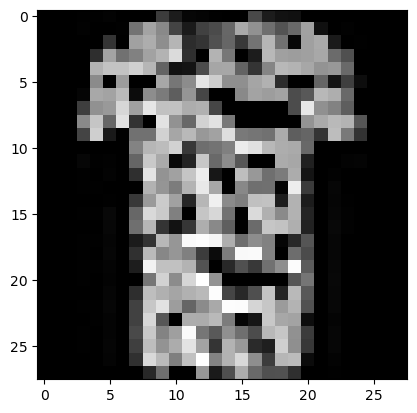

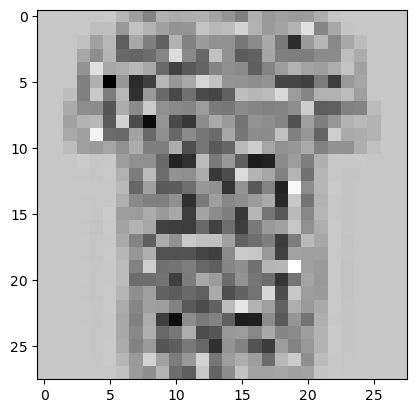

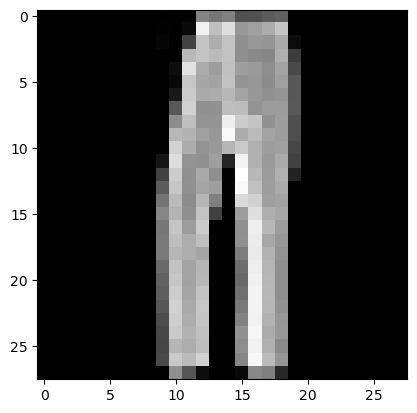

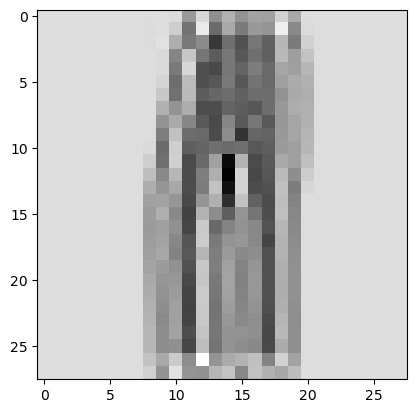

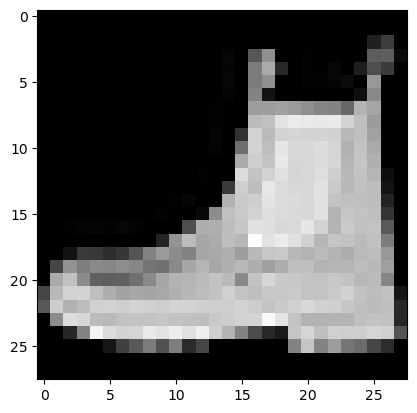

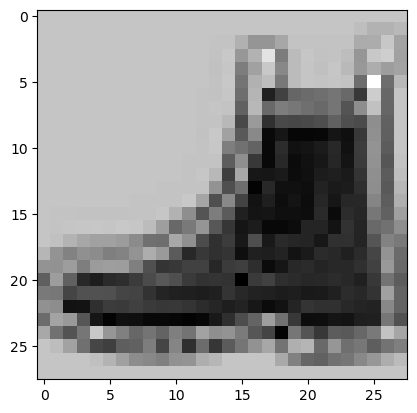

In [44]:
# test the forward pass
cnn_clf_forward_test = Conv(1, 1, 3, 1, 1)
cnn_clf_forward_test.weight = np.array([
    [-1, -1, -1],
    [-1, 4, -1],
    [-1, -1, -1]
])[np.newaxis, :, :, np.newaxis] # edge detection
cnn_clf_forward_test.forward(Xfm_train[:3])
for x_in, x_out in zip(Xfm_train[:3], cnn_clf_forward_test._output):
    plt.figure()
    plt.imshow(x_in[:, :, 0], cmap='gray')
    plt.show()
    plt.figure()
    plt.imshow(x_out[:, :, 0], cmap = 'gray')

In [45]:
# first test of backward pass
cnn_clf_backward_test_1 = Conv(1, 1, 3, 1, 1)
x = np.arange(25).reshape(1,5,5,1).astype(float)
cnn_clf_backward_test_1.weight = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])[np.newaxis, :, :, np.newaxis].astype('float64') # edge detection
cnn_clf_backward_test_1.forward(x)
grad_output = np.eye(5)[np.newaxis, :, :, np.newaxis]
cnn_clf_backward_test_1.backward(grad_output)
print(f'The kernel is \n{cnn_clf_backward_test_1.weight.squeeze()}')
print(f'The input is \n{x.squeeze()}')
print(f'The output is \n{cnn_clf_backward_test_1._output.squeeze()}')
print(f'The grad_output is \n{grad_output.squeeze()}')
print(f'The grad_weight is \n{cnn_clf_backward_test_1._grad_weight.squeeze()}')
print(f'The grad_input is \n{cnn_clf_backward_test_1._grad_input.squeeze()}')
# verified correct by hand calculation =)


The kernel is 
[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]
The input is 
[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. 11. 12. 13. 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]
The output is 
[[-12. -12.  -9.  -6.  12.]
 [ 12.   0.   0.   0.  30.]
 [ 27.   0.   0.   0.  45.]
 [ 42.   0.   0.   0.  60.]
 [108.  78.  81.  84. 132.]]
The grad_output is 
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
The grad_weight is 
[[36. 40. 24.]
 [56. 60. 40.]
 [48. 56. 60.]]
The grad_input is 
[[-1. -1. -1.  0.  0.  0.  0.]
 [-1.  7. -2. -1.  0.  0.  0.]
 [-1. -2.  6. -2. -1.  0.  0.]
 [ 0. -1. -2.  6. -2. -1.  0.]
 [ 0.  0. -1. -2.  6. -2. -1.]
 [ 0.  0.  0. -1. -2.  7. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.]]


In [46]:
# interesting pattern:
for m in range(5, 10):
    x = np.arange(m ** 2).reshape(1, m, m, 1).astype(float)
    K = np.array([
        [-1, -1, -1],
        [-1, 8, -1],
        [-1, -1, -1]
    ]).astype(float).reshape(1, 3, 3, 1)
    print(Convolve(x, K, 1, 1).squeeze())
    print(f'The ({m-1}) x ({m-1}) center is just 0!')

[[-12. -12.  -9.  -6.  12.]
 [ 12.   0.   0.   0.  30.]
 [ 27.   0.   0.   0.  45.]
 [ 42.   0.   0.   0.  60.]
 [108.  78.  81.  84. 132.]]
The (4) x (4) center is just 0!
[[-14. -15. -12.  -9.  -6.  15.]
 [ 15.   0.   0.   0.   0.  36.]
 [ 33.   0.   0.   0.   0.  54.]
 [ 51.   0.   0.   0.   0.  72.]
 [ 69.   0.   0.   0.   0.  90.]
 [160. 111. 114. 117. 120. 189.]]
The (5) x (5) center is just 0!
[[-16. -18. -15. -12.  -9.  -6.  18.]
 [ 18.   0.   0.   0.   0.   0.  42.]
 [ 39.   0.   0.   0.   0.   0.  63.]
 [ 60.   0.   0.   0.   0.   0.  84.]
 [ 81.   0.   0.   0.   0.   0. 105.]
 [102.   0.   0.   0.   0.   0. 126.]
 [222. 150. 153. 156. 159. 162. 256.]]
The (6) x (6) center is just 0!
[[-18. -21. -18. -15. -12.  -9.  -6.  21.]
 [ 21.   0.   0.   0.   0.   0.   0.  48.]
 [ 45.   0.   0.   0.   0.   0.   0.  72.]
 [ 69.   0.   0.   0.   0.   0.   0.  96.]
 [ 93.   0.   0.   0.   0.   0.   0. 120.]
 [117.   0.   0.   0.   0.   0.   0. 144.]
 [141.   0.   0.   0.   0.   0.   0. 16

In [47]:
# second test of backward pass
x2 = np.random.randn(2, 7, 7, 1)
cnn_clf_backward_test_2 = Conv(1, 1, 3, 1, 1)
cnn_clf_backward_test_2.forward(x2)
grad_output2 = np.random.randn(*cnn_clf_backward_test_2._output.shape)
cnn_clf_backward_test_2.backward(grad_output2)
print(f'The kernel is \n{cnn_clf_backward_test_2.weight.squeeze()}')
print(f'The input is \n{x2.squeeze()}')
print(f'The output is \n{cnn_clf_backward_test_2._output.squeeze()}')
print(f'The grad_output is \n{grad_output2.squeeze()}')
print(f'The grad_weight is \n{cnn_clf_backward_test_2._grad_weight.squeeze()}')
print(f'The grad_input is \n{cnn_clf_backward_test_2._grad_input.squeeze()}')
# NO ZEROS AND SHAPES MATCH MEANS WE ARE (likely) ALL GOOD =)

The kernel is 
[[-0.22141156 -0.4937324  -0.00678558]
 [ 0.4197855  -0.90049204  0.10385616]
 [-0.6613025   1.11062512 -0.52915758]]
The input is 
[[[-0.61974918  0.87865139  1.08313329  0.14125596  0.84742926
   -0.11735598 -0.6721609 ]
  [-0.10502124  0.70589    -1.488181    1.16975875 -0.37731718
   -0.35307757 -0.89691217]
  [-0.67668214  1.1619711  -0.28789887 -1.25329317  1.01472221
    0.39068044  0.43409488]
  [ 0.50788173  0.01253661 -0.41324084  0.56102291  1.82411431
    0.05763055  0.83173543]
  [-1.17695336 -0.56250327  0.73188877 -0.71537745  1.05615399
    0.09032495  0.14879802]
  [-2.34252335  0.13797477  0.38447818 -1.32820936  0.21388577
   -0.15429452  0.62750419]
  [-0.55288695 -0.13453969 -0.3301886   0.56943404 -0.55140363
    1.84924642 -0.05829097]]

 [[-0.80407765 -1.48725722  0.01732831  1.78284968 -0.7246622
   -1.53010644  0.94303326]
  [ 0.96385904 -0.2473472  -0.47492693  0.54670866 -1.15850407
   -0.21827388  0.77924735]
  [-1.12664273  0.44902202 -1.751

In [66]:
# now we implement a pooling layer
class maxpool(Module):
    def __init__(self, kernel_size: int = 2, stride: int = 2) -> None:
        super(maxpool).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        # param to account for intermediary step in forward pass
        # inspired by this blog post
        # https://medium.com/latinxinai/vectorized-convolution-operation-using-numpy-b122fd52fba3
        self._dil_input = None # shape (m, h_out, w_out, kernel_size, kernel_size, c)
    def forward(self, x: np.ndarray) -> np.ndarray:
        ''''
        Forward pass of the pooling layer.'
        '''
        assert x.ndim == 4
        # init stuff
        m, h, w, c = x.shape
        m_stride, h_stride, w_stride, c_stride = x.strides
        h_out = (h - self.kernel_size) // self.stride + 1
        w_out = (w - self.kernel_size) // self.stride + 1
        # stuff done here is done with EXTREME CARE
        # EVIL vectorized code
        dil_shape = (m, h_out, w_out, self.kernel_size, self.kernel_size, c)
        dil_strides = (m_stride, h_stride * self.stride, w_stride * self.stride, h_stride, w_stride, c_stride)
        # cache stuff
        self._dil_input = np.lib.stride_tricks.as_strided(x, dil_shape, dil_strides)
        self._input = x
        self._output = np.max(self._dil_input, axis = (3, 4))
        self._check_forward_attrs()
    
    def backward(self, grad_output: np.ndarray) -> np.ndarray:
        '''
        Computes gradient of loss w.r.t. input.
        Args:
            grad_output: Gradient of loss w.r.t. output of the module. Shape (m, h_out, w_out, c)
        '''
        self._grad_output = grad_output
        self._grad_input = np.zeros_like(self._input)
        # mask
        m, h_out, w_out, k_h, k_w, c = self._dil_input.shape
        flat_dil = self._dil_input.reshape(m, h_out, w_out, k_h * k_w, c)
        flat_idx = np.argmax(flat_dil, axis = 3, keepdims=True)
        mask = np.eye(k_h * k_w)[flat_idx].reshape(m, h_out, w_out, k_h, k_w, c)
        dil_grad_out = grad_output[:, :, :, np.newaxis, np.newaxis, :] * mask
        # more evil vectorized code
        m, h, w, c = self._grad_input.shape
        m_str, h_str, w_str, c_str = self._grad_input.strides
        h_out = (h - k_h) // self.stride + 1
        w_out = (w - k_w) // self.stride + 1
        dil_shape = (m, h_out, w_out, k_h, k_w, c)
        dil_strides = (m_str, h_str * self.stride, w_str * self.stride, h_str, w_str, c_str)
        dil_grad_in = np.lib.stride_tricks.as_strided(self._grad_input, dil_shape, dil_strides)
        dil_grad_in += dil_grad_out # add the contributions of the gradient
        # result will automatically be updated in the _grad_input attribute, since dil_grad_in is a view of _grad_input
#### TASK 6 CODE

#### Package output for uploading to Kaggle

In order to upload your results to Kaggle, load the test data, use your model to predict outputs, and then write the outputs to a csv file. You will upload the csv file stored at `fname` to the Kaggle competition.

In [ ]:
# Save the CSV file of labels. UPLOAD THIS FILE
fname = '/content/fmnist_test_pred.csv'
output = np.vstack((np.arange(y_test_preds.shape[0]), y_test_preds)).T
np.savetxt(fname, output, fmt="%d", delimiter=',', comments='', header='id,label')